Paper Information :
    Generative Well-intentioned Networks 
    https://papers.nips.cc/paper/9467-generative-well-intentioned-networks.pdf

Authors of code:
    Yasin Berk Gültekin - 1942119
    Hasan Ali Duran - 1942119
    


## Challenges Encountered When Implementing Paper:

* There was not enough detail about how BNN was implemented. The number of layers was not specified. 
We could not fully obtain the BNN results mentioned in Paper. The BNN we have implemented makes predictions with higher scores. 
This situation caused difficulties in the exact occurrence of qualitative results.

* The biggest problem we encountered during GAN implementation was that it was not clear enough how the
Generator and Discriminator inputs should be processed in the model. It was not specified how many layers 
or what types of layers were used. In addition, the pictures produced by the generator appeared similar to those given
as input to the Generator. There was no explanation for how this problem was solved in paper implementation. The new method which is transformation loss used during the Discriminator's loss calculation was not sufficiently explained.(You can find our assumptions for the models(like number of layers and type of layers) in the implementation.

In [6]:
!pip install -v pyro-ppl

from torchvision import transforms
from torchvision import datasets
import os.path
import os
import numpy as np
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import subprocess
import pyro.distributions as dist
import pyro
from matplotlib import colors
from pyro import optim
from pyro.infer import SVI, Trace_ELBO


Non-user install because site-packages writeable
Created temporary directory: C:\Users\Lenovo\AppData\Local\Temp\pip-ephem-wheel-cache-x0ausrdi
Created temporary directory: C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-ntczw9ee
Initialized build tracking at C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-ntczw9ee
Created build tracker: C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-ntczw9ee
Entered build tracker: C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-ntczw9ee
Created temporary directory: C:\Users\Lenovo\AppData\Local\Temp\pip-install-vmsntved
Cleaning up...
Removed build tracker: 'C:\\Users\\Lenovo\\AppData\\Local\\Temp\\pip-req-tracker-ntczw9ee'


### HyperParameters 

In [10]:
parameters = {
    "threshold": [0.7, 0.8, 0.9],
    "critic_threshold": 0.95,
    "n_critic": 5,
    "n_epochs_Classifier": 30,
    "n_epochs_GAN": 200000,
    "batch_size": 128,
    "lr_Classifier": 0.001, # learning rate for Classifier model
    "lr_GAN": 0.0001,  # learning rate for GAN models
    "b1": 0.5,
    "b2": 0.9,
    "latent_dim": 100,
    "n_classes": 10,
    "img_size": 28,
    "channels": 1,
    "lambda_gp": 10, # lambda for gradient penalty
    "lambda_loss": 10, # lambda for transformation penalty
    "continue_on_existing_training": 0,
    "cuda": 1,
    "run_download_sh": 0
}


In [11]:
img_shape = (parameters["channels"], parameters["img_size"], parameters["img_size"])

cuda = True if parameters["cuda"] else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# ---------------------
#  Setting Datasets
# ---------------------
if parameters["run_download_sh"]:
    subprocess.call("download.sh", shell=True)

trainset = datasets.MNIST(
    root="",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(parameters["img_size"]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))

testset = datasets.MNIST(
    root="",
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(parameters["img_size"]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))

trainloader = torch.utils.data.DataLoader(
    trainset,
    drop_last=True,
    batch_size=parameters["batch_size"],
    shuffle=True,
)

testloader = torch.utils.data.DataLoader(
    testset,
    drop_last=True,
    batch_size=parameters["batch_size"],
    shuffle=False,
)

Classifier Model (Bayesian Neural Network)

In [12]:
# ---------------------
#  BNN - Classifier Model
# ---------------------
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()

        self.out = nn.Sequential(
            nn.Linear(parameters["img_size"] ** 2, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = x.flatten(1)
        return self.out(x)


model = BNN()
if cuda:
    model.cuda()


# ---------------------
#  Stochastic Variational Inference's Module
# ---------------------
def module(x, y):
    priors = {}
    for iterator in model.named_parameters():
        name, param = iterator
        zeros = torch.zeros_like(param.data)
        ones = torch.ones_like(param.data)
        priors[name] = dist.Normal(loc=zeros,
                                   scale=ones)

    lifted_module = pyro.random_module("module", model, priors)
    lifted_module_method = lifted_module()
    lhat = F.log_softmax(lifted_module_method(x), 1)
    pyro.sample("obs", dist.Categorical(logits=lhat), obs=y)


# ---------------------
#  Stochastic Variational Inference's Guide
# ---------------------
def guide(x, y):
    priors = {}
    for iterator in model.named_parameters():
        name, param = iterator
        priors[name] = dist.Normal(loc=pyro.param(name + '.mu', torch.randn_like(param)),
                                   scale=F.softplus(pyro.param(name + '.sigma', torch.randn_like(param))))

    lifted_module = pyro.random_module('module', model, priors)
    return lifted_module()


opt = optim.Adam({'lr': parameters["lr_Classifier"]})
svi = SVI(module, guide, opt, loss=Trace_ELBO())

# ---------------------
#  Classifier's prediction method
# ---------------------
def predict(x, y):
    sampled_models = [guide(None, None) for _ in range(parameters["n_classes"])]
    yhats = [model(x.to(device)).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    predsProbs, preds = torch.max(F.softmax(mean).to(device), 1)
    return predsProbs, preds


## Training And Saving Models

In [23]:
# ---------------------
#  Trains Classifier Model
# ---------------------
def train_classifier_model():
    pyro.clear_param_store()

    total_loss = 0
    for epoch in range(parameters["n_epochs_Classifier"]):
        loss = 0
        for x, y in trainloader:
            loss += svi.step(x.flatten(1).to(device), y.to(device))
        total_loss = loss / len(trainloader.dataset)
        print("Epoch: %d Loss: %f" % (epoch + 1, total_loss))

    pyro.get_param_store().save('paramstore.out')
    torch.save(model.state_dict(), 'ClassifierModel.pt')

train_classifier_model()

# ---------------------
#  Trains Generative Adverserial Network model
# ---------------------
def train_GAN(dataloader):
    batches_done = 0
    for epoch in range(parameters["n_epochs_GAN"]):
        for i, (imgs, labels) in enumerate(dataloader):
            hot_labels = create_one_hot_label(labels)

            real_images = Variable(imgs.type(FloatTensor))
            labels = Variable(labels.type(LongTensor))

            discriminator_optimizer.zero_grad()

            z = Variable(FloatTensor(np.random.normal(0, 1, (parameters["batch_size"], parameters["latent_dim"]))))

            generated_images = generator(z, real_images)

            d_loss = calculate_discriminator_loss(real_images, labels, generated_images, hot_labels)

            d_loss.backward()
            discriminator_optimizer.step()

            generator_optimizer.zero_grad()


            if i % parameters["n_critic"] == 0:

                generated_images = generator(z, real_images)

                fake_validity = discriminator(generated_images, hot_labels)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                generator_optimizer.step()

                print_progress(epoch, d_loss, g_loss)

                batches_done += batches_done + parameters["n_critic"]

                if batches_done % 100 == 0:
                    save_image(generated_images.data[:25], "images/wgan/%d.png" % batches_done, nrow=5, normalize=True)

    save_GAN_models()
    
# ---------------------
#  Saves Generator and Discriminator Models
# ---------------------
def save_GAN_models():
    torch.save(generator.state_dict(), 'GeneratorModel.pt')
    torch.save(discriminator.state_dict(), 'DiscriminatorModel.pt')


Epoch: 1 Loss: 6414.542196
Epoch: 2 Loss: 5750.218853
Epoch: 3 Loss: 5376.938865


In [24]:
# ---------------------
#  Test for Classifier
# ---------------------
def test_classifier():
    correct = 0
    total = 0
    for x, y in testloader:
        x, y = arrange_data_tensors(x, y)
        predsProbs, preds = predict(x.flatten(1), y)
        total += parameters["batch_size"]
        correct += (preds == y).sum().item()
    print("Accuracy: %f" % (correct / total))

test_classifier()

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.857973


In [15]:
# ---------------------
#  Trains or loads classifier model
# ---------------------
def create_classifier_model():
    if (not os.path.exists('ClassifierModel.pt') or not os.path.exists('paramstore.out')):
        train_classifier_model()
        test_classifier()
    else:
        pyro.get_param_store().load('paramstore.out')
        model.load_state_dict(torch.load('ClassifierModel.pt'))

create_classifier_model()
mask = []


# ---------------------
#  Creates Mask To Train Discriminator With P_Critic
# ---------------------
def create_critic_mask():
    print("Creating mask to train model with only critic dataset...")
    for i in range(int(len(trainset) / parameters["batch_size"])):
        # obtain one batch of training images
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        images, labels = arrange_data_tensors(images, labels)

        predsProbs, preds= predict(images, labels)
        # convert output probabilities to predicted class
        # predsProbs, preds = torch.max(output, 1)
        for j in range(parameters["batch_size"]):
            mask.append(1 if predsProbs[j].item() > parameters["critic_threshold"] else 0)


create_critic_mask()
mask = FloatTensor(mask)


# ---------------------
#  Sampler Class to use mask
# ---------------------
class SpecialSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, mask, data_source):
        self.mask = mask
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(mask)])

    def __len__(self):
        return len(self.data_source)


Creating mask to train model with only critic dataset...


C:\Users\Lenovo\anaconda3\lib\site-packages\pyro\primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [2]:
# ---------------------
#  Calculates Transformation Loss While Calculating Discriminator Loss
# ---------------------
def calculate_transformation_loss(img, label):
    loss = 0
    loss += svi.evaluate_loss(img.flatten(1).to(device), label.to(device))
    return loss/(parameters["batch_size"]**2)


# ---------------------
#  Loads Models Or Trains Classifier, Generator, Discriminator Models
# ---------------------
def load_or_train_models():
    create_classifier_model()

    if parameters["continue_on_existing_training"] or (
            not (os.path.exists('DiscriminatorModel.pt') or os.path.exists('GeneratorModel.pt'))):
        sampler = SpecialSampler(mask, trainset)
        special_loader = torch.utils.data.DataLoader(
            trainset,
            drop_last=True,
            batch_size=parameters["batch_size"],
            sampler=sampler,
            shuffle=False
        )
        if parameters["continue_on_existing_training"] == True and (
                os.path.exists('DiscriminatorModel.pt') and os.path.exists('GeneratorModel.pt')):
            load_GAN_models()

        train_GAN(special_loader)
    else:
        load_GAN_models()



In [16]:
# ---------------------
#  Generator Class
# ---------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.fc = nn.Linear(parameters["latent_dim"], parameters["channels"] * parameters["img_size"] ** 2)

        self.init_size = parameters["img_size"] // 4  # Initial size before upsampling

        self.l1 = nn.Sequential(nn.Conv2d(parameters["channels"] * 2, 64, 3, 1, 1), nn.ReLU(inplace=True))

        self.conv_blocks_for_image = nn.Sequential(
            nn.Conv2d(1, 1, 3, stride=2, padding=1),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(1, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(16, 0.8),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Tanh(),
        )

        self.l2 = nn.Sequential(
            nn.Linear(4 * parameters["img_size"] ** 2, parameters["channels"] * parameters["img_size"] ** 2),
            nn.Tanh(),
        )

    def forward(self, z, img):
        # img = play_with_image(img)
        first_z = self.fc(z).view(
            [parameters["batch_size"], 1, int(parameters["img_size"]), int(parameters["img_size"])])
        gen_input = torch.cat((FloatTensor(img), first_z), 1)
        out = self.l1(gen_input)
        generated_img = self.conv_blocks(out)
        return generated_img


# ---------------------
#  Discriminator Class
# ---------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + parameters["n_classes"], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        gen_input = torch.cat(
            (img.view(parameters["img_size"] * parameters["img_size"], parameters["batch_size"]),
             labels.view(parameters["n_classes"], parameters["batch_size"])), 0). \
            view(parameters["batch_size"], parameters["img_size"] * parameters["img_size"] + parameters["n_classes"])
        validity = self.model(gen_input)
        return validity


generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=parameters["lr_GAN"],
                                       betas=(parameters["b1"], parameters["b2"]))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=parameters["lr_GAN"],
                                           betas=(parameters["b1"], parameters["b2"]))


In [14]:
# ---------------------
#  Computes Gradient Penalty
# ---------------------
def compute_gradient_penalty(discriminator, real_samples, fake_samples, hot_labels):
    alpha = FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    gradients = autograd.grad(
        discriminator(interpolates, hot_labels),
        interpolates,
        Variable(FloatTensor(parameters["batch_size"], 1).fill_(1.0), requires_grad=False),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    gradients = gradients[0].view(gradients[0].size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ---------------------
#  Creates One Hot Label Representation
# ---------------------
def create_one_hot_label(labels):
    hot_labels = []
    hot_label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(len(labels)):
        hot_label[labels[i]] = 1
        hot_labels.append(hot_label)

    return FloatTensor(hot_labels)


# ---------------------
#  Calculates Discriminator Loss
# ---------------------
def calculate_discriminator_loss(real_images, real_labels, fake_images, hot_labels):
    real_validity = discriminator(real_images, hot_labels)
    fake_validity = discriminator(fake_images, hot_labels)

    # Calculating gradient penalty
    gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, fake_images.data, hot_labels)
    # Calculating transformation penalty
    transformation_loss = calculate_transformation_loss(fake_images, real_labels)

    # Calculating total penalty
    total_loss = -torch.mean(real_validity) + \
                 torch.mean(fake_validity) + \
                 parameters["lambda_gp"] * gradient_penalty + \
                 parameters["lambda_loss"] * transformation_loss

    return total_loss


# ---------------------
#  Prints GAN progress
# ---------------------
def print_progress(epoch, d_loss, g_loss):
    print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, parameters["n_epochs_GAN"], d_loss.item(), g_loss.item())
          )

    
# ---------------------
#  Converts Images and Labels
# ---------------------
def arrange_data_tensors(images, labels):
    images = Variable(images.type(FloatTensor))
    labels = Variable(labels.type(LongTensor))

    return images, labels


In [18]:

# ---------------------
#  Loads Generator and Discriminator Models
# ---------------------
def load_GAN_models():
    generator.load_state_dict(torch.load('GeneratorModel.pt'))
    discriminator.load_state_dict(torch.load('DiscriminatorModel.pt'))
    

In [19]:
# ---------------------
#  Generates image from generator and saves if save parameter is true
# ---------------------
def sample_single_image(images, index, image_path, save):
    z = Variable(FloatTensor(np.random.normal(0, 1, (parameters["batch_size"], parameters["latent_dim"]))))
    generated_images = generator(z, images)
    if (save == True):
        save_image(generated_images[index].data, image_path, nrow=1, normalize=True)

    return generated_images[index].data


# ---------------------
#  Shows the given image
# ---------------------
def show_image(img):
    img = img.view(parameters["img_size"], parameters["img_size"])
    img = img.type(torch.FloatTensor).detach().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()



## Loading Models And Printing Results

test_models produces quantitive and qualitive results.

1)Quantitive result is generating a handwritten number which has a certainty that is under threshold.(Figure 2 from Paper)

2)Qualitive result is printing three rows of the "Table 1" from the paper.
It produces results for [0.7, 0.8, 0.9] thresholds (Three rows of the Table 1)

Generating images and printing results...
-------------------Results for Threshold: 0.700000 -------------------


C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


----------Qualitative Results for Threshold----------
Original Image : 0.556490 (Prediction Acc) || Old Label:  3


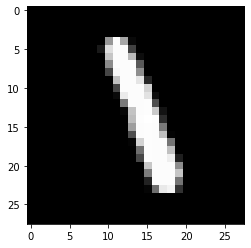

Generated Image: 1.000000 (Prediction Acc) || New Label:  1


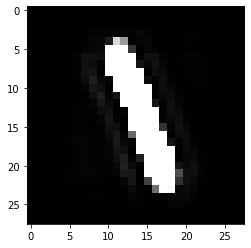

----------Qualitative Results for Threshold----------

----------Quantitative Results for Threshold----------
Reject            : 0.066000
BNN Accuracy      : 43.939394
BNN+GWIN Accuracy : 62.121212
Rejected Accuracy : 18
Overall Accuracy  : 0.012000
Error             : 27.548209
----------Quantitative Results for Threshold----------
-------------------Results for Threshold: 0.700000 -------------------


-------------------Results for Threshold: 0.800000 -------------------
----------Qualitative Results for Threshold----------
Original Image : 0.714864 (Prediction Acc) || Old Label:  5


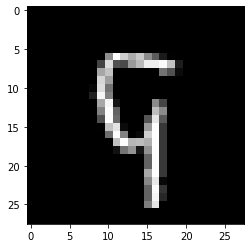

Generated Image: 1.000000 (Prediction Acc) || New Label:  9


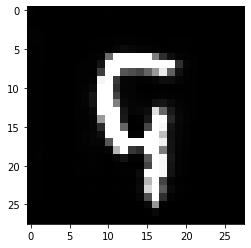

----------Qualitative Results for Threshold----------

----------Quantitative Results for Threshold----------
Reject            : 0.105000
BNN Accuracy      : 40.952381
BNN+GWIN Accuracy : 59.047619
Rejected Accuracy : 18
Overall Accuracy  : 0.019000
Error             : 17.233560
----------Quantitative Results for Threshold----------
-------------------Results for Threshold: 0.800000 -------------------


-------------------Results for Threshold: 0.900000 -------------------
----------Qualitative Results for Threshold----------
Original Image : 0.628692 (Prediction Acc) || Old Label:  4


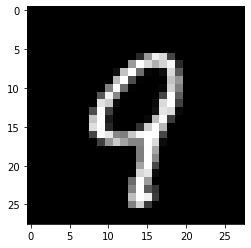

Generated Image: 1.000000 (Prediction Acc) || New Label:  9


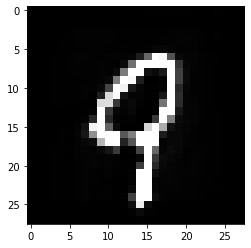

----------Qualitative Results for Threshold----------

----------Quantitative Results for Threshold----------
Reject            : 0.166000
BNN Accuracy      : 37.349398
BNN+GWIN Accuracy : 60.843373
Rejected Accuracy : 23
Overall Accuracy  : 0.039000
Error             : 14.152998
----------Quantitative Results for Threshold----------
-------------------Results for Threshold: 0.900000 -------------------




In [32]:
# ---------------------
#  Test
# ---------------------
def test_models():
    load_or_train_models()
    print("Generating images and printing results...")
    for threshold_index in range(len(parameters["threshold"])):
        print('-------------------Results for Threshold: %2f -------------------' % parameters["threshold"][threshold_index])
        counter = 0
        probUnderThreshold = 0
        probUnderThresholdButCorrectClassified = 0
        probUnderThresholdThenClassifiedCorrectClassified = 0
        probAboveThresholdAndCorrectClassified = 0
        probAboveThresholdAlsoClassifiedCorrectClassified = 0

        for i in range(10):
            for j in range(int(len(testset) / parameters["batch_size"])):
                # obtain one batch of training images
                dataiter = iter(testloader)
                images, labels = dataiter.next()

                images, labels = arrange_data_tensors(images, labels)

                # get sample outputs
                output = model(images)

                predsProbs, preds = predict(images, labels)

                # convert output probabilities to predicted class
                # predsProbs, preds = torch.max(output, 1)

                for k in range(parameters["batch_size"]):

                    idx = (i * int(len(testset))) + (j * parameters["batch_size"]) + k

                    trueLabel = labels[k].item()
                    modelsPrediction = preds[k].item()
                    modelsPredictionProb = predsProbs[k].item()

                    if (modelsPredictionProb < parameters["threshold"][threshold_index]):
                        probUnderThreshold = probUnderThreshold + 1
                        if (trueLabel == modelsPrediction):
                            probUnderThresholdButCorrectClassified = probUnderThresholdButCorrectClassified + 1
                    else:
                        if (trueLabel == modelsPrediction):
                            probAboveThresholdAndCorrectClassified = probAboveThresholdAndCorrectClassified + 1

                    if (predsProbs[k] < parameters["threshold"][threshold_index]):
                        save_image(images[k], "images/result_images/%d" % idx + "_original_image.png", nrow=1,
                                   normalize=True)

                        generatedImage = sample_single_image(images, k,
                                                             "images/result_images/%d" % idx + "_generated_image_.png",
                                                             True)
                        lastPredsProbs, lastPreds = predict(generatedImage.view(1, 1, 28, 28), labels)

                        if not modelsPrediction == trueLabel and lastPreds.item() == trueLabel and counter < 1:
                            print('----------Qualitative Results for Threshold----------')
                            print('Original Image : %2f (Prediction Acc) || Old Label: %2d' % (predsProbs[k], preds[k]))
                            show_image(images[k])
                            print("Generated Image: %2f (Prediction Acc) || New Label: %2d" % (lastPredsProbs.item(), lastPreds.item()))
                            show_image(generatedImage)
                            counter = counter + 1
                            print('----------Qualitative Results for Threshold----------\n')

                        if (lastPreds.item() == trueLabel):
                            probUnderThresholdThenClassifiedCorrectClassified = probUnderThresholdThenClassifiedCorrectClassified + 1

        total_images = 100000.0

        reject = (float(100 * probUnderThreshold) / total_images)
        bnnAcc = (100 * probUnderThresholdButCorrectClassified / probUnderThreshold)
        bnn_and_gwinAcc = (100 * probUnderThresholdThenClassifiedCorrectClassified / probUnderThreshold)
        overallAcc = (float(100 * (
                probUnderThresholdThenClassifiedCorrectClassified - probUnderThresholdButCorrectClassified)) / total_images)
        error = (100 * (bnn_and_gwinAcc - bnnAcc)) / probUnderThreshold

        print('----------Quantitative Results for Threshold----------')
        print('Reject            : %2f' % reject)
        print('BNN Accuracy      : %2f' % bnnAcc)
        print('BNN+GWIN Accuracy : %2f' % bnn_and_gwinAcc)
        print('Rejected Accuracy : %2d' % (bnn_and_gwinAcc - bnnAcc))
        print('Overall Accuracy  : %2f' % overallAcc)
        print('Error             : %2f' % error)
        print('----------Quantitative Results for Threshold----------')

        print('-------------------Results for Threshold: %2f -------------------\n\n' % parameters["threshold"][threshold_index])

        
test_models()
